# goals
* explore the mismatch between lensed, RP and NP waveforms
* explore the conditions for indistinguishable waveforms

# import modules

In [1]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver1 import *
from modules.default_params_ver1 import *
from modules.functions_ver2 import *

# assign params

default: mcz = 20 solar masses, MLz = 2000 solar masses

In [2]:
lens_params, RP_params, NP_params = set_to_params(lens_params_1, RP_params_1, NP_params_1)

In [3]:
%matplotlib inline
# colors = ['k', 'r', 'b', 'c', 'm', 'y', 'g']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)  # type: ignore

# check $f^{-7/6}$ power law

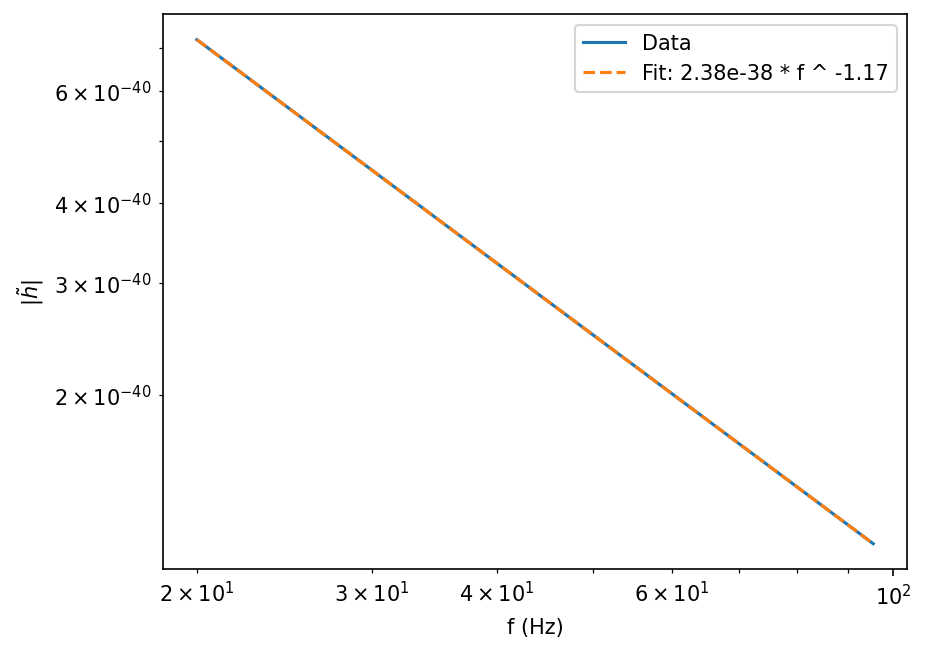

In [4]:
gw_NP = get_gw(NP_params)
h_NP = gw_NP["waveform"]
h_NP_abs = np.abs(h_NP)
f_arr = gw_NP["f_array"]

# Take the logarithm of the data
log_h = np.log(h_NP_abs)
log_f = np.log(f_arr)

# Use polyfit to fit a line to the logarithm of the data
coeffs = np.polyfit(log_f, log_h, 1)

# The coefficients of the line are the parameters of the power law
a = np.exp(coeffs[1])  # The coefficient a is given by exp(intercept)
b = coeffs[0]  # The power b is the slope of the line

# Plot the original data and the fit
plt.loglog(f_arr, h_NP_abs, label="Data")
plt.loglog(f_arr, a * f_arr**b, ls="--", label=f"Fit: {a:.2e} * f ^ {b:.2f}")
plt.xlabel("f (Hz)")
plt.ylabel(r"$|\~{h}|$")
plt.legend()
plt.show()

In [4]:
# List the mergers in the catalog
for merger_name in catalog.Catalog():
    print(merger_name)

GW170823-v1
GW170818-v1
GW170817-v3
GW170814-v3
GW170809-v1
GW170729-v1
GW170608-v3
GW170104-v2
GW151226-v2
GW151012-v3
GW150914-v3


In [5]:
# Either from the catalog as a whole
# https://pycbc.org/pycbc/latest/html/_modules/pycbc/catalog.html#Merger

c = catalog.Catalog()
mchirp = c.median1d("mchirp")
print(mchirp)

# or from a specific merger
m = catalog.Merger("GW170817")
mchirp_gw170817 = m.median1d("mchirp")
print("GW170817: {}".format(mchirp_gw170817))

# print parameters that can be read
print(m.data.keys())

[29.2   26.5    1.186 24.1   24.9   35.4    7.9   21.4    8.9   15.2
 28.6  ]
GW170817: 1.186
dict_keys(['commonName', 'version', 'catalog.shortName', 'GPS', 'reference', 'jsonurl', 'strain', 'mass_1_source', 'mass_1_source_lower', 'mass_1_source_upper', 'mass_1_source_unit', 'mass_2_source', 'mass_2_source_lower', 'mass_2_source_upper', 'mass_2_source_unit', 'network_matched_filter_snr', 'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper', 'network_matched_filter_snr_unit', 'luminosity_distance', 'luminosity_distance_lower', 'luminosity_distance_upper', 'luminosity_distance_unit', 'chi_eff', 'chi_eff_lower', 'chi_eff_upper', 'chi_eff_unit', 'total_mass_source', 'total_mass_source_lower', 'total_mass_source_upper', 'total_mass_source_unit', 'chirp_mass_source', 'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass_source_unit', 'chirp_mass', 'chirp_mass_lower', 'chirp_mass_upper', 'chirp_mass_unit', 'redshift', 'redshift_lower', 'redshift_upper', 'redshif

In [7]:
m = catalog.Merger("GW150914")
source_mchirp = m.median1d("mchirp")
redshift = m.median1d("redshift")
det_mchirp = source_mchirp * (1 + redshift)

print("Chirp Mass of GW150914")
print("Source Frame: {} Solar Masses".format(source_mchirp))
print("Detector Frame: {} Solar Masses".format(det_mchirp))

Chirp Mass of GW150914
Source Frame: 28.6 Solar Masses
Detector Frame: 31.174000000000003 Solar Masses


Duration: 32.0s Start: 1126259447 End: 1126259479


Text(0.5, 1.0, 'GW150914 Strain')

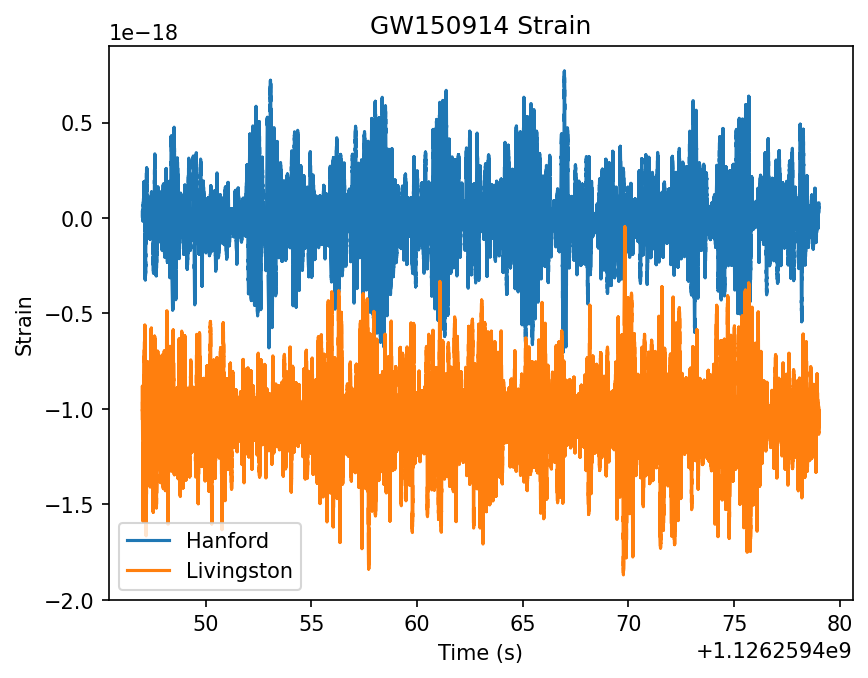

In [8]:
m = catalog.Merger("GW150914")

# Get the time series data around GW150914 from Hanford
# 'ts_han' is a pycbc.types.TimeSeries object which contains
# gravitational-wave strain in this instance and has metadata
# such as the start time, and sample rate.
ts_han = m.strain("H1")

# And now livingston
ts_liv = m.strain("L1")

# We can see how much data was returned and its boundaries
# Note: All times are given in seconds since the GPS time epoch
print(
    "Duration: {}s Start: {} End: {}".format(
        ts_han.duration, int(ts_han.start_time), int(ts_han.end_time)
    )
)

# We can directly plot the time series as follows
plt.plot(ts_han.sample_times, ts_han, label="Hanford")
plt.ylabel("Strain")
plt.xlabel("Time (s)")
plt.plot(ts_liv.sample_times, ts_liv, label="Livingston")
plt.ylabel("Strain")
plt.xlabel("Time (s)")
plt.legend()
plt.title("GW150914 Strain")

Text(0.5, 0.98, 'GW150914 Strain in Frequency Domain')

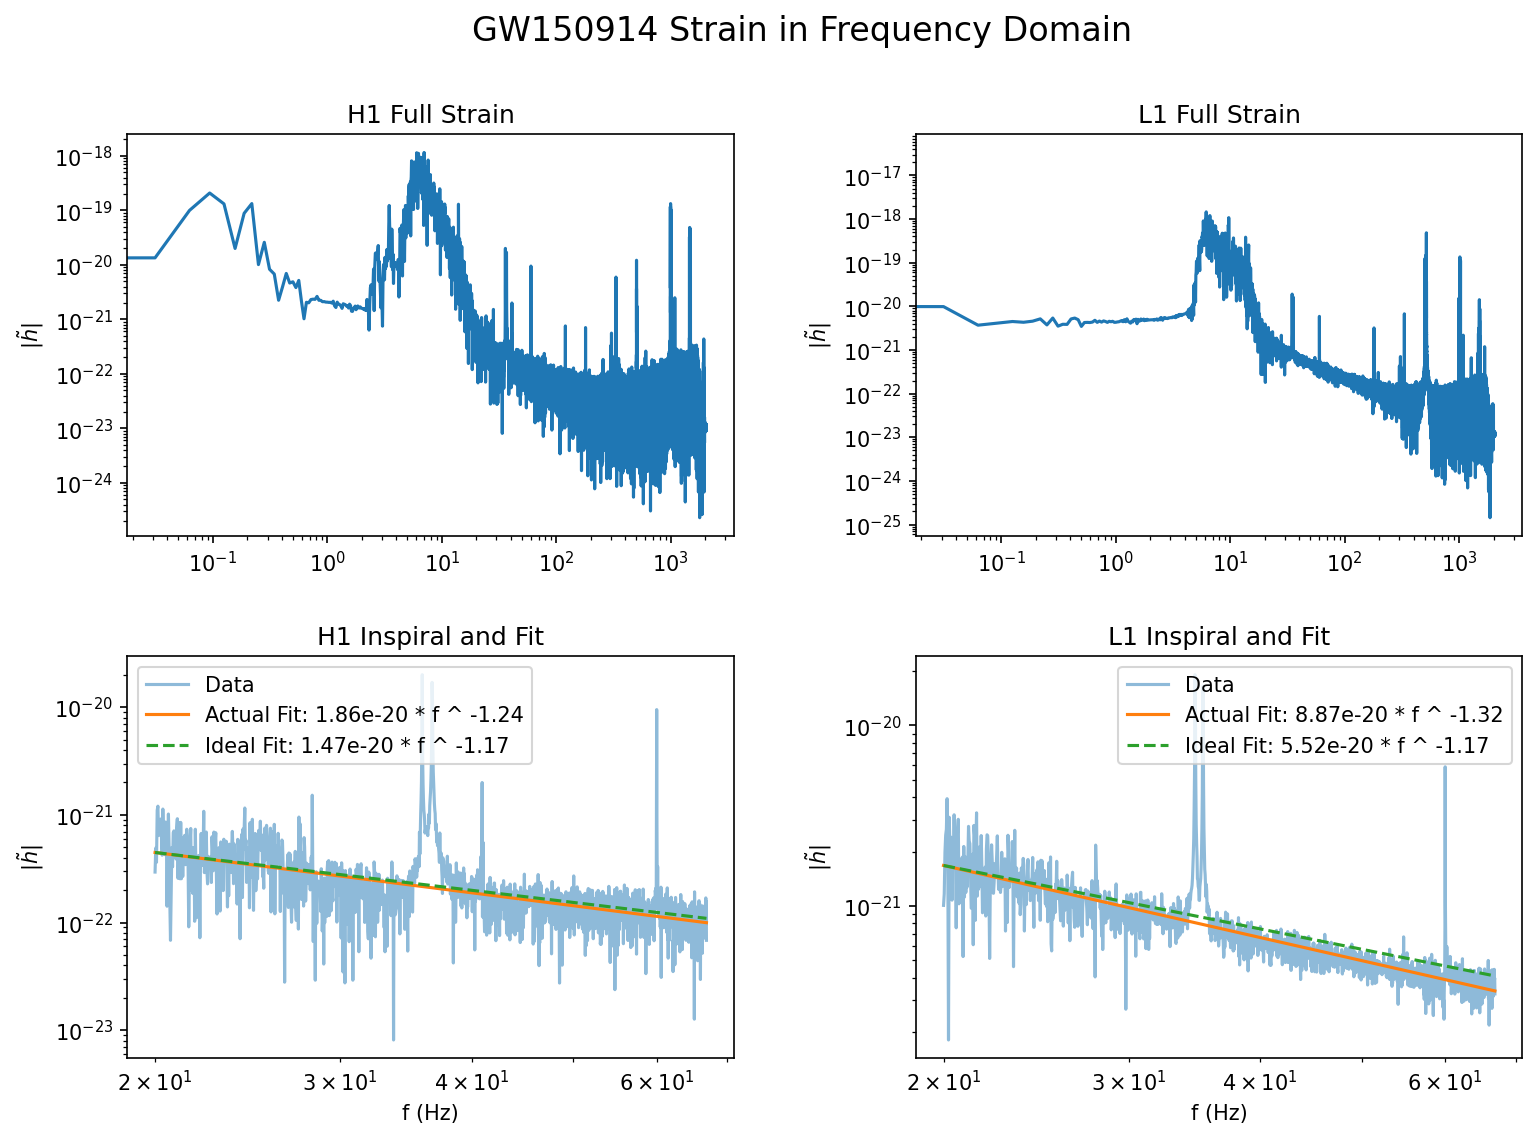

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Choose GW event
merger = catalog.Merger("GW150914")
source_mchirp = merger.median1d("mchirp")
f_cut = get_fcut_from_mcz(source_mchirp, eta=0.25)

# Convert time series to frequency series
fs_han = np.abs(ts_han.to_frequencyseries())
f_arr_han = fs_han.sample_frequencies

axes[0, 0].loglog(f_arr_han, fs_han, label="H1")
axes[0, 0].set_ylabel(r"$|\~{h}|$")
axes[0, 0].set_title("H1 Full Strain")

# Filter and fit the strain in frequency domain to a power law
fs_han_filtered = fs_han[np.logical_and(20 <= f_arr_han, f_arr_han <= f_cut)]
f_arr_han_filtered = f_arr_han[np.logical_and(20 <= f_arr_han, f_arr_han <= f_cut)]

# Take the logarithm of the data
log_h = np.log(fs_han_filtered)
log_f = np.log(f_arr_han_filtered)

# Use polyfit to fit a line to the logarithm of the data
coeffs = np.polyfit(log_f, log_h, 1)

# The coefficients of the line are the parameters of the power law
a = np.exp(coeffs[1])  # The coefficient a is given by exp(intercept)
b = coeffs[0]  # The power b is the slope of the line

# Calculate the ideal fit
ideal_b = -7 / 6
ideal_a = a * (
    f_arr_han_filtered[0] ** (b - ideal_b)
)  # Adjust the coefficient a to match the actual fit at f_arr_filtered[0]

# Plot the original data and the fit
axes[1, 0].loglog(f_arr_han_filtered, fs_han_filtered, alpha=0.5, label="Data")
axes[1, 0].loglog(
    f_arr_han_filtered,
    a * f_arr_han_filtered**b,
    ls="-",
    label=f"Actual Fit: {a:.2e} * f ^ {b:.2f}",
)
axes[1, 0].loglog(
    f_arr_han_filtered,
    ideal_a * f_arr_han_filtered**ideal_b,
    ls="--",
    label=f"Ideal Fit: {ideal_a:.2e} * f ^ {ideal_b:.2f}",
)
axes[1, 0].set_xlabel("f (Hz)")
axes[1, 0].set_ylabel(r"$|\~{h}|$")
axes[1, 0].legend()
axes[1, 0].set_title("H1 Inspiral and Fit")

# Copy the above code for L1 strain

fs_liv = np.abs(ts_liv.to_frequencyseries())
f_arr_liv = fs_liv.sample_frequencies

axes[0, 1].loglog(f_arr_liv, fs_liv, label="L1")
axes[0, 1].set_ylabel(r"$|\~{h}|$")
axes[0, 1].set_title("L1 Full Strain")

# Filter and fit the strain in frequency domain to a power law
fs_liv_filtered = fs_liv[np.logical_and(20 <= f_arr_liv, f_arr_liv <= f_cut)]
f_arr_liv_filtered = f_arr_liv[np.logical_and(20 <= f_arr_liv, f_arr_liv <= f_cut)]

# Take the logarithm of the data
log_h = np.log(fs_liv_filtered)
log_f = np.log(f_arr_liv_filtered)

# Use polyfit to fit a line to the logarithm of the data
coeffs = np.polyfit(log_f, log_h, 1)

# The coefficients of the line are the parameters of the power law
a = np.exp(coeffs[1])  # The coefficient a is given by exp(intercept)
b = coeffs[0]  # The power b is the slope of the line

# Calculate the ideal fit
ideal_b = -7 / 6
ideal_a = a * (
    f_arr_liv_filtered[0] ** (b - ideal_b)
)  # Adjust the coefficient a to match the actual fit at f_arr_filtered[0]

# Plot the original data and the fit
axes[1, 1].loglog(f_arr_liv_filtered, fs_liv_filtered, alpha=0.5, label="Data")
axes[1, 1].loglog(
    f_arr_liv_filtered,
    a * f_arr_liv_filtered**b,
    ls="-",
    label=f"Actual Fit: {a:.2e} * f ^ {b:.2f}",
)
axes[1, 1].loglog(
    f_arr_liv_filtered,
    ideal_a * f_arr_liv_filtered**ideal_b,
    ls="--",
    label=f"Ideal Fit: {ideal_a:.2e} * f ^ {ideal_b:.2f}",
)
axes[1, 1].set_xlabel("f (Hz)")
axes[1, 1].set_ylabel(r"$|\~{h}|$")
axes[1, 1].legend()
axes[1, 1].set_title("L1 Inspiral and Fit")

fig.suptitle("GW150914 Strain in Frequency Domain", fontsize=16)

# write general function

In [19]:
def filter_strain(fs, f_arr, fcut):
    fs_filtered = fs[np.logical_and(20 <= f_arr, f_arr <= fcut)]
    f_arr_filtered = f_arr[np.logical_and(20 <= f_arr, f_arr <= fcut)]
    return fs_filtered, f_arr_filtered


def fit_power_law(fs, f_arr):
    # Take the logarithm of the data
    log_h = np.log(fs)
    log_f = np.log(f_arr)

    # Use polyfit to fit a line to the logarithm of the data
    coeffs = np.polyfit(log_f, log_h, 1)

    # The coefficients of the line are the parameters of the power law
    a = np.exp(coeffs[1])  # The coefficient a is given by exp(intercept)
    b = coeffs[0]  # The power b is the slope of the line
    return a, b


def plot_filtered_strain_and_fit(fs, f_arr, fcut, ax, label):
    fs_filtered, f_arr_filtered = filter_strain(fs, f_arr, fcut)
    a, b = fit_power_law(fs_filtered, f_arr_filtered)
    ideal_b = -7 / 6
    ideal_a = a * (
        f_arr_filtered[0] ** (b - ideal_b)
    )  # Adjust the coefficient a to match the actual fit at f_arr_filtered[0]
    ax.loglog(f_arr_filtered, fs_filtered, c="k", alpha=0.5, label="Data")
    ax.loglog(
        f_arr_filtered,
        a * f_arr_filtered**b,
        c="r",
        ls="-",
        label=f"Actual Fit: {a:.2e} * f ^ {b:.2f}",
    )
    ax.loglog(
        f_arr_filtered,
        ideal_a * f_arr_filtered**ideal_b,
        c="b",
        ls="--",
        label=f"Ideal Fit: {ideal_a:.2e} * f ^ {ideal_b:.2f}",
    )
    ax.set_xlabel("f (Hz)")
    ax.set_ylabel(r"$|\~{h}|$")
    ax.legend()
    ax.set_title(label)


def plot_merger_and_fit(merger):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    src_mcz = merger.median1d("mchirp")
    f_cut = get_fcut_from_mcz(src_mcz, eta=0.25)
    mass1 = merger.median1d("mass1")
    mass2 = merger.median1d("mass2")
    q = mass2 / mass1

    # Get time series of GW event from Hanford and Livingston
    ts_han = merger.strain("H1")
    ts_liv = merger.strain("L1")

    # Convert time series to frequency series
    fs_han = np.abs(ts_han.to_frequencyseries())
    f_arr_han = fs_han.sample_frequencies
    fs_liv = np.abs(ts_liv.to_frequencyseries())
    f_arr_liv = fs_liv.sample_frequencies

    # Plot original strain in frequency domain
    axes[0, 0].loglog(f_arr_han, fs_han, c="k", label="H1")
    axes[0, 0].set_ylabel(r"$|\~{h}|$")
    axes[0, 0].set_title("H1 Full Strain")

    axes[0, 1].loglog(f_arr_liv, fs_liv, c="k", label="L1")
    axes[0, 1].set_ylabel(r"$|\~{h}|$")
    axes[0, 1].set_title("L1 Full Strain")

    # Plot filtered strain and fit in frequency domain
    plot_filtered_strain_and_fit(
        fs_han, f_arr_han, f_cut, axes[1, 0], "H1 Inspiral and Fit"
    )
    plot_filtered_strain_and_fit(
        fs_liv, f_arr_liv, f_cut, axes[1, 1], "L1 Inspiral and Fit"
    )

    fig.suptitle(f'{merger.data["commonName"]} Strain in Frequency Domain, $q$ = {q:.2f}', fontsize=16)

# plot all mergers in catalog

In [22]:
# List the mergers in the catalog
for merger_name in catalog.Catalog():
    merger = catalog.Merger(merger_name[:-3])
    mass1 = merger.median1d("mass1")
    mass2 = merger.median1d("mass2")
    q = mass2 / mass1
    print(f"{merger_name}: mass 1 = {mass1:.2f}, mass 2 = {mass2:.2f}, q = {q:.2f}")

GW170823-v1: mass 1 = 39.50, mass 2 = 29.00, q = 0.73
GW170818-v1: mass 1 = 35.40, mass 2 = 26.70, q = 0.75
GW170817-v3: mass 1 = 1.46, mass 2 = 1.27, q = 0.87
GW170814-v3: mass 1 = 30.60, mass 2 = 25.20, q = 0.82
GW170809-v1: mass 1 = 35.00, mass 2 = 23.80, q = 0.68
GW170729-v1: mass 1 = 50.20, mass 2 = 34.00, q = 0.68
GW170608-v3: mass 1 = 11.00, mass 2 = 7.60, q = 0.69
GW170104-v2: mass 1 = 30.80, mass 2 = 20.00, q = 0.65
GW151226-v2: mass 1 = 13.70, mass 2 = 7.70, q = 0.56
GW151012-v3: mass 1 = 23.20, mass 2 = 13.60, q = 0.59
GW150914-v3: mass 1 = 35.60, mass 2 = 30.60, q = 0.86


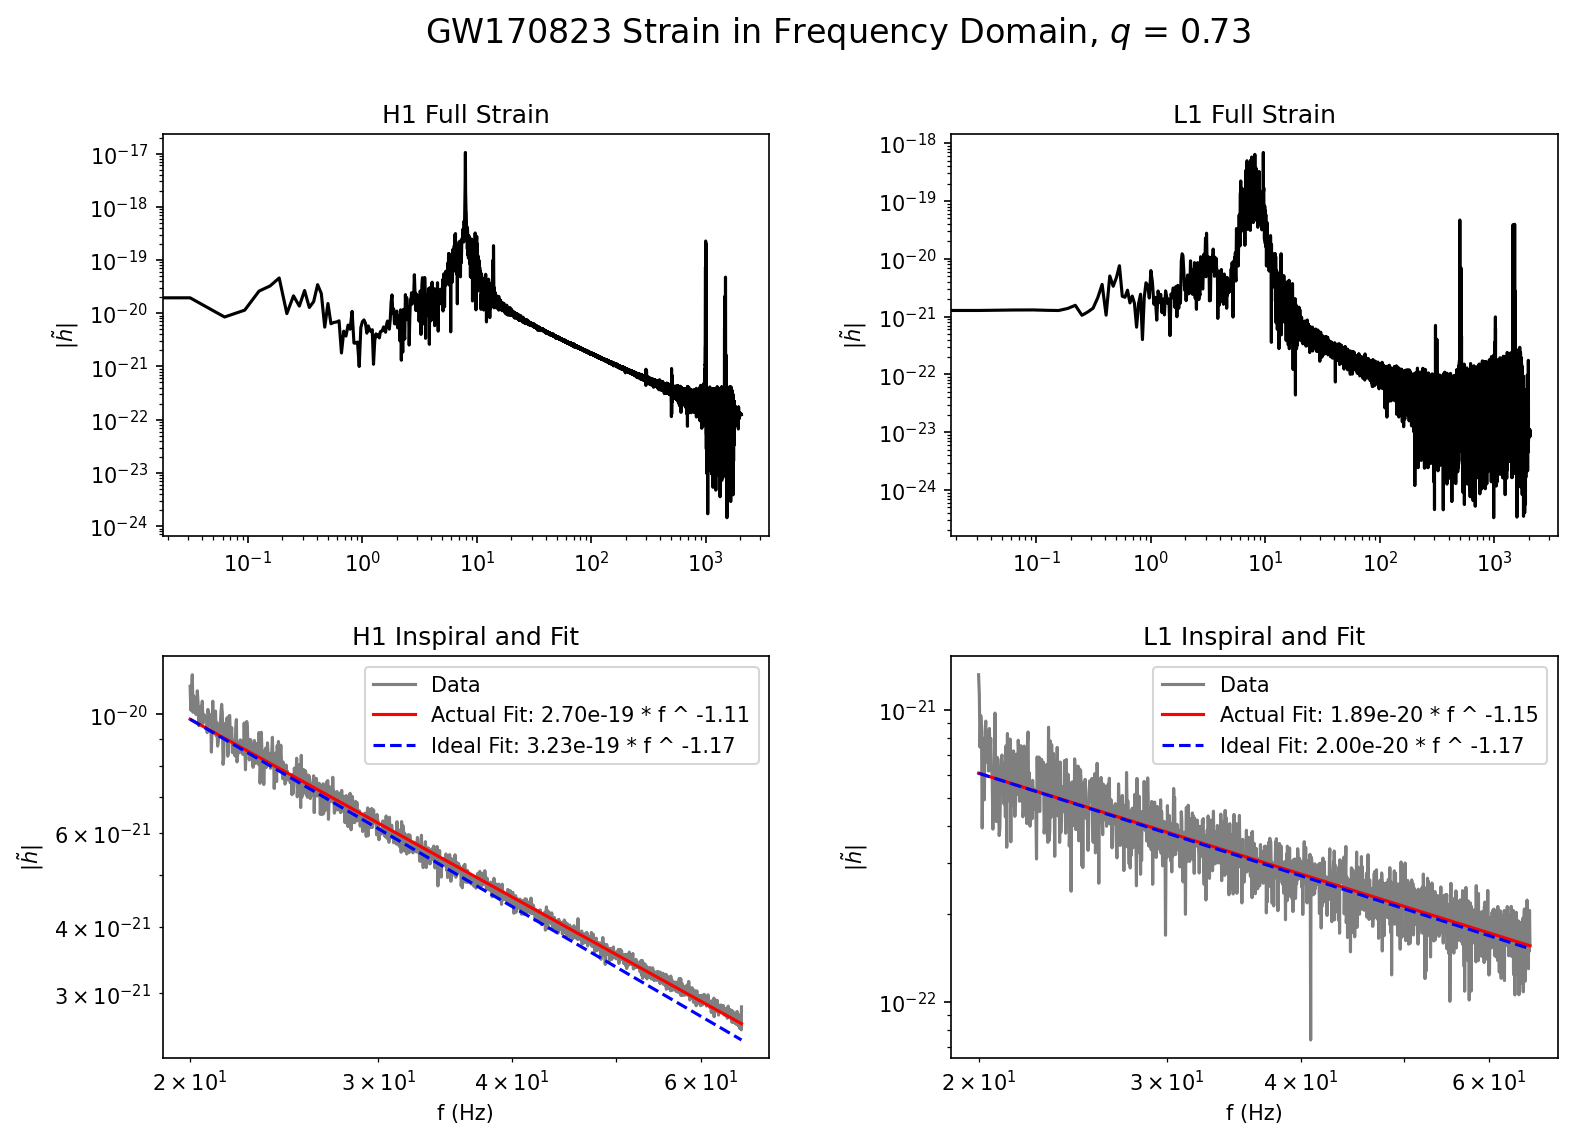

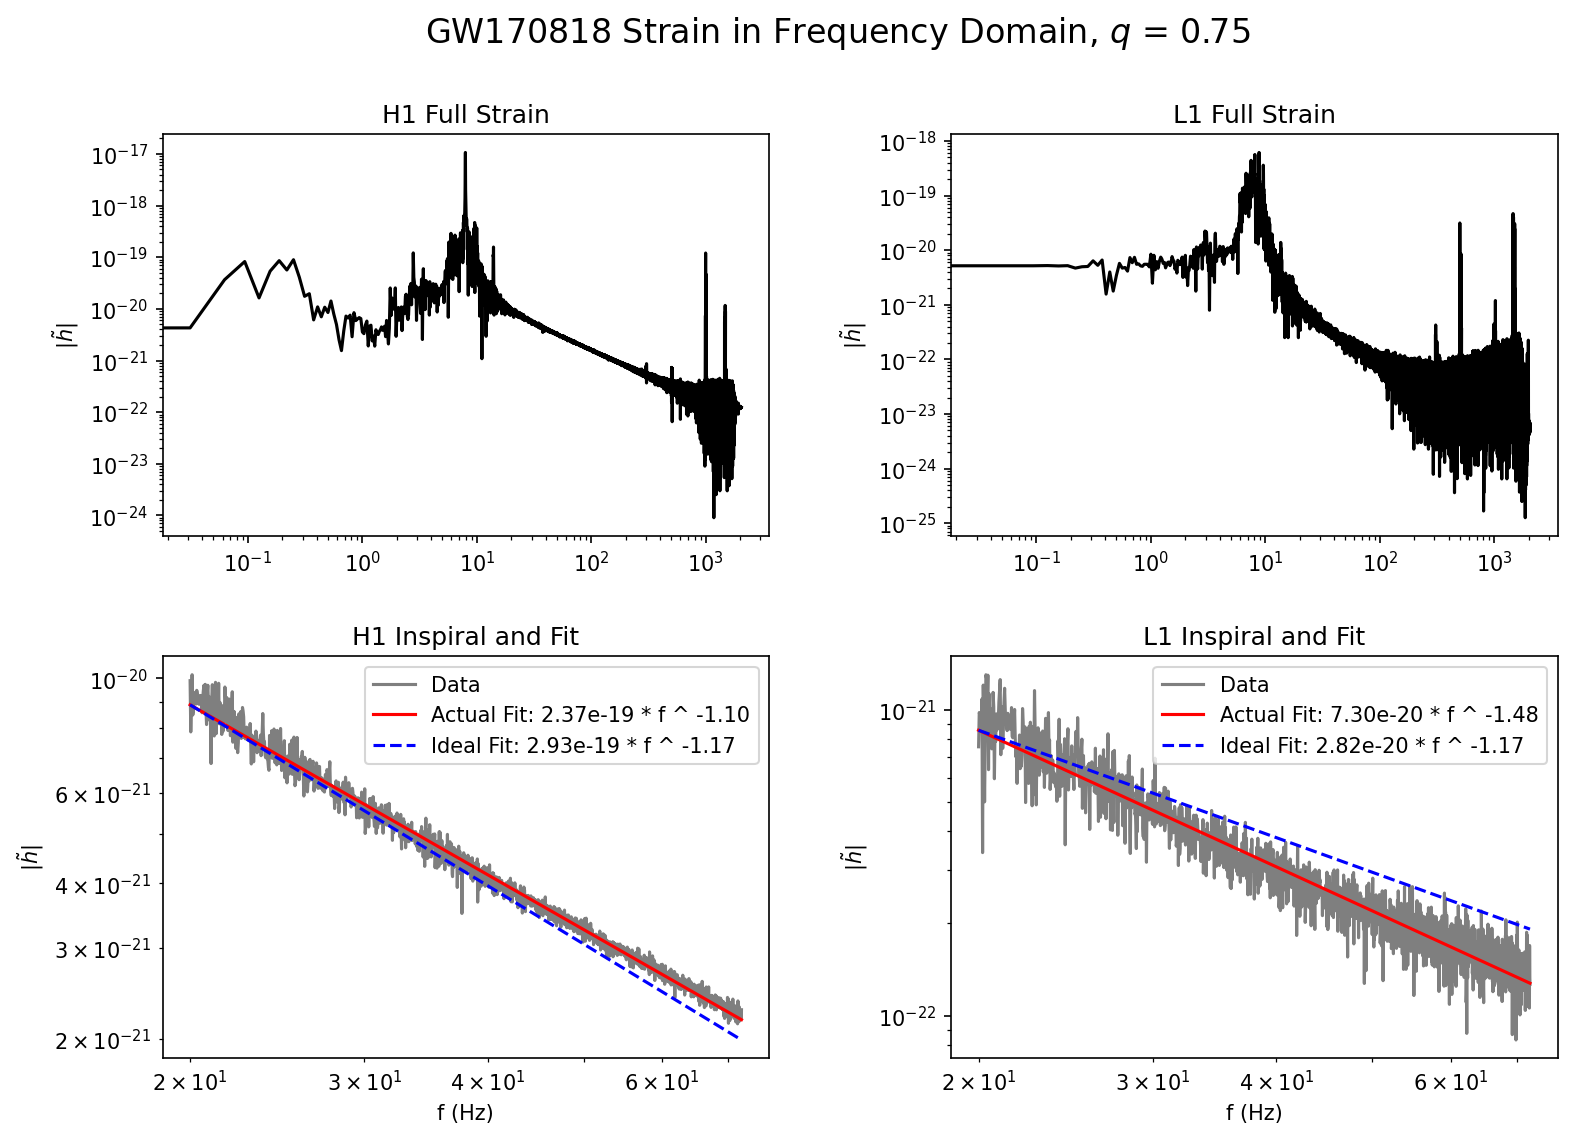

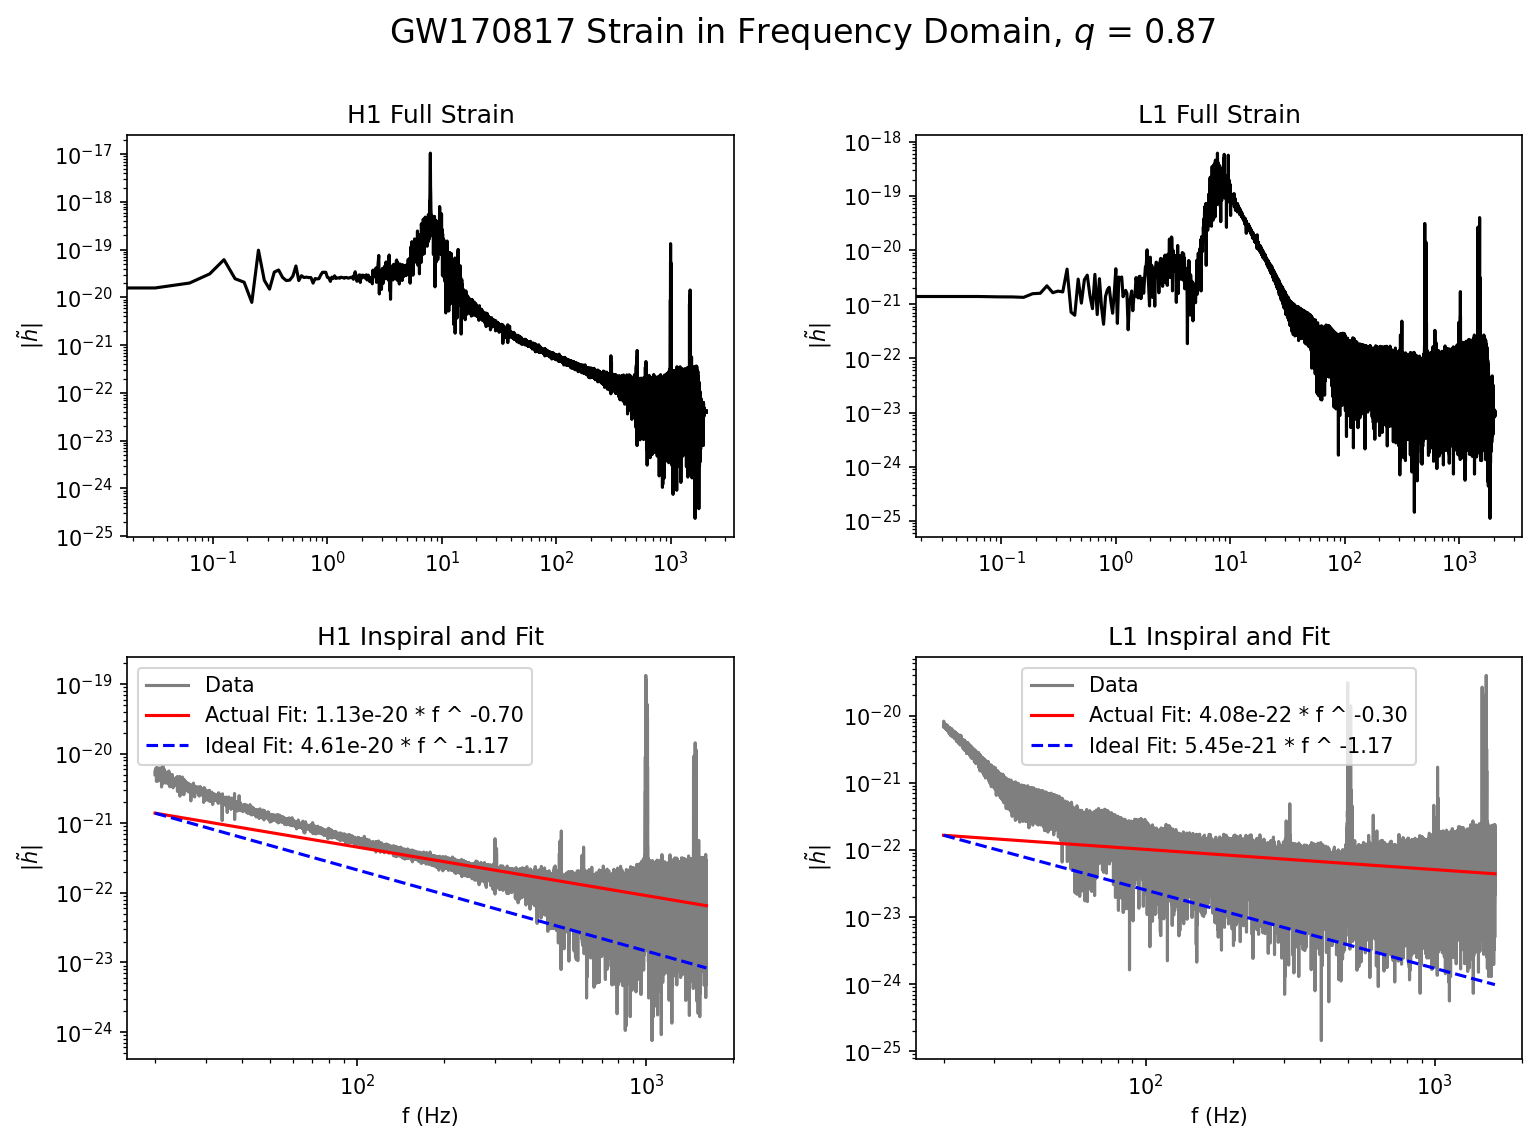

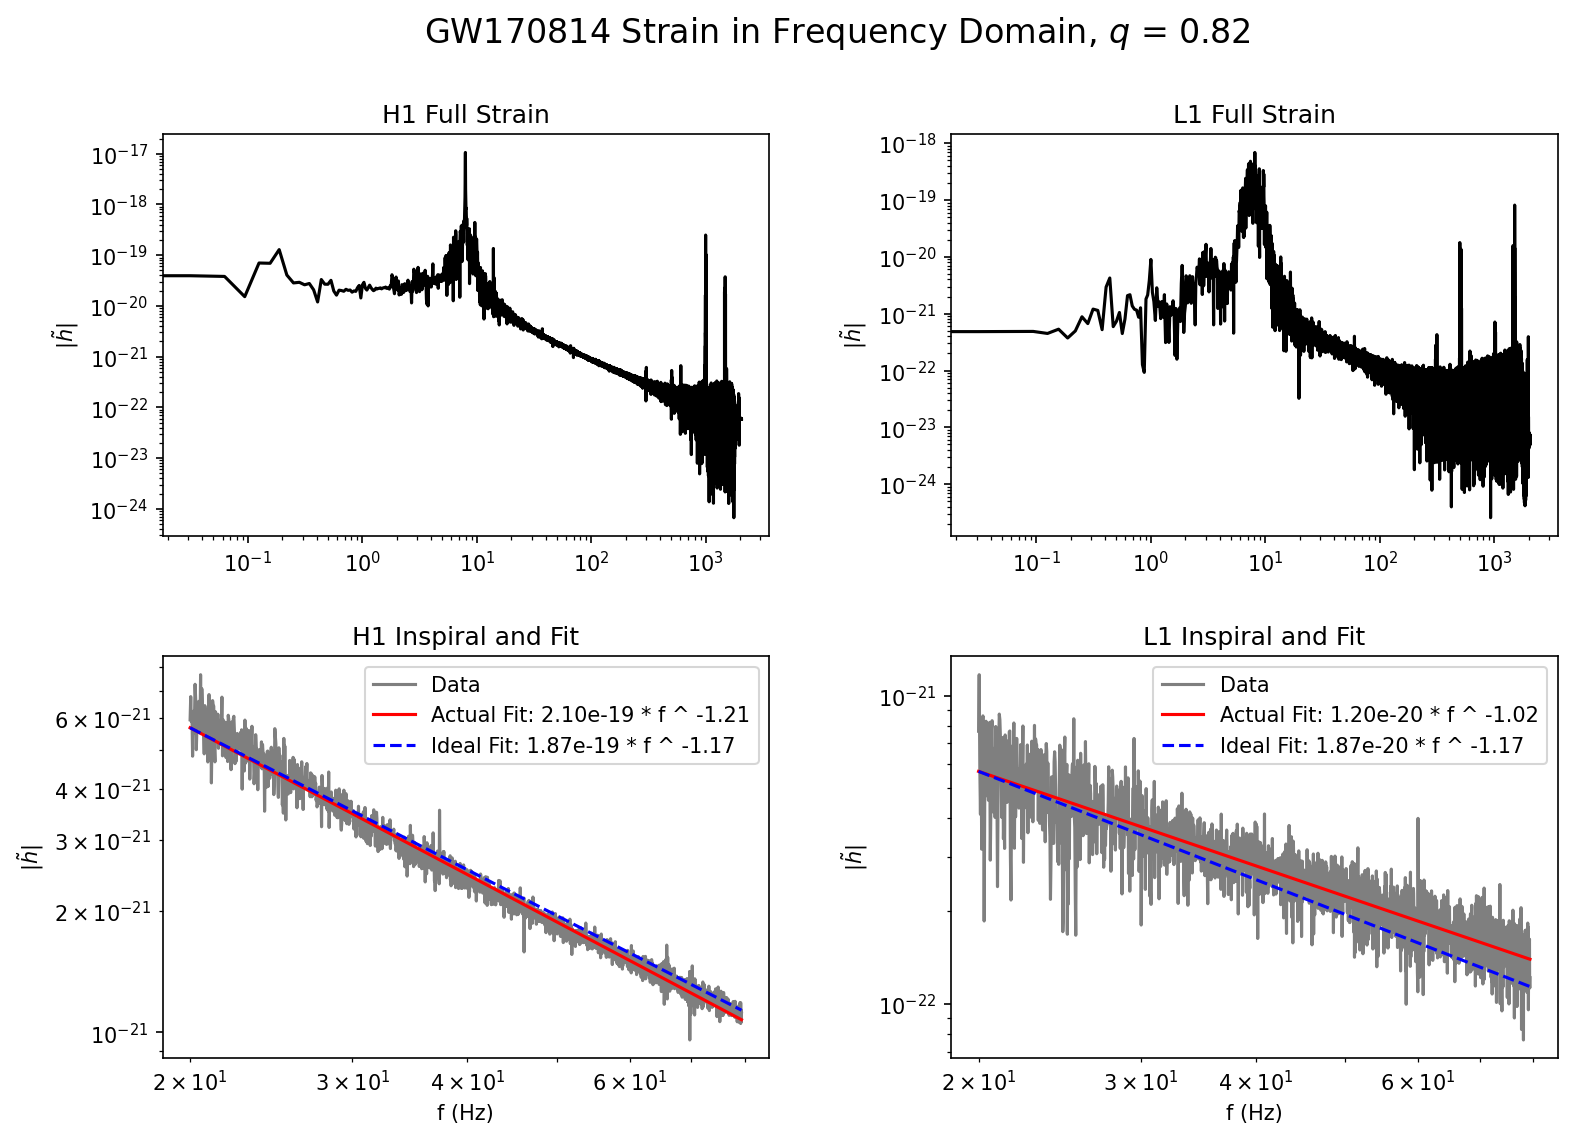

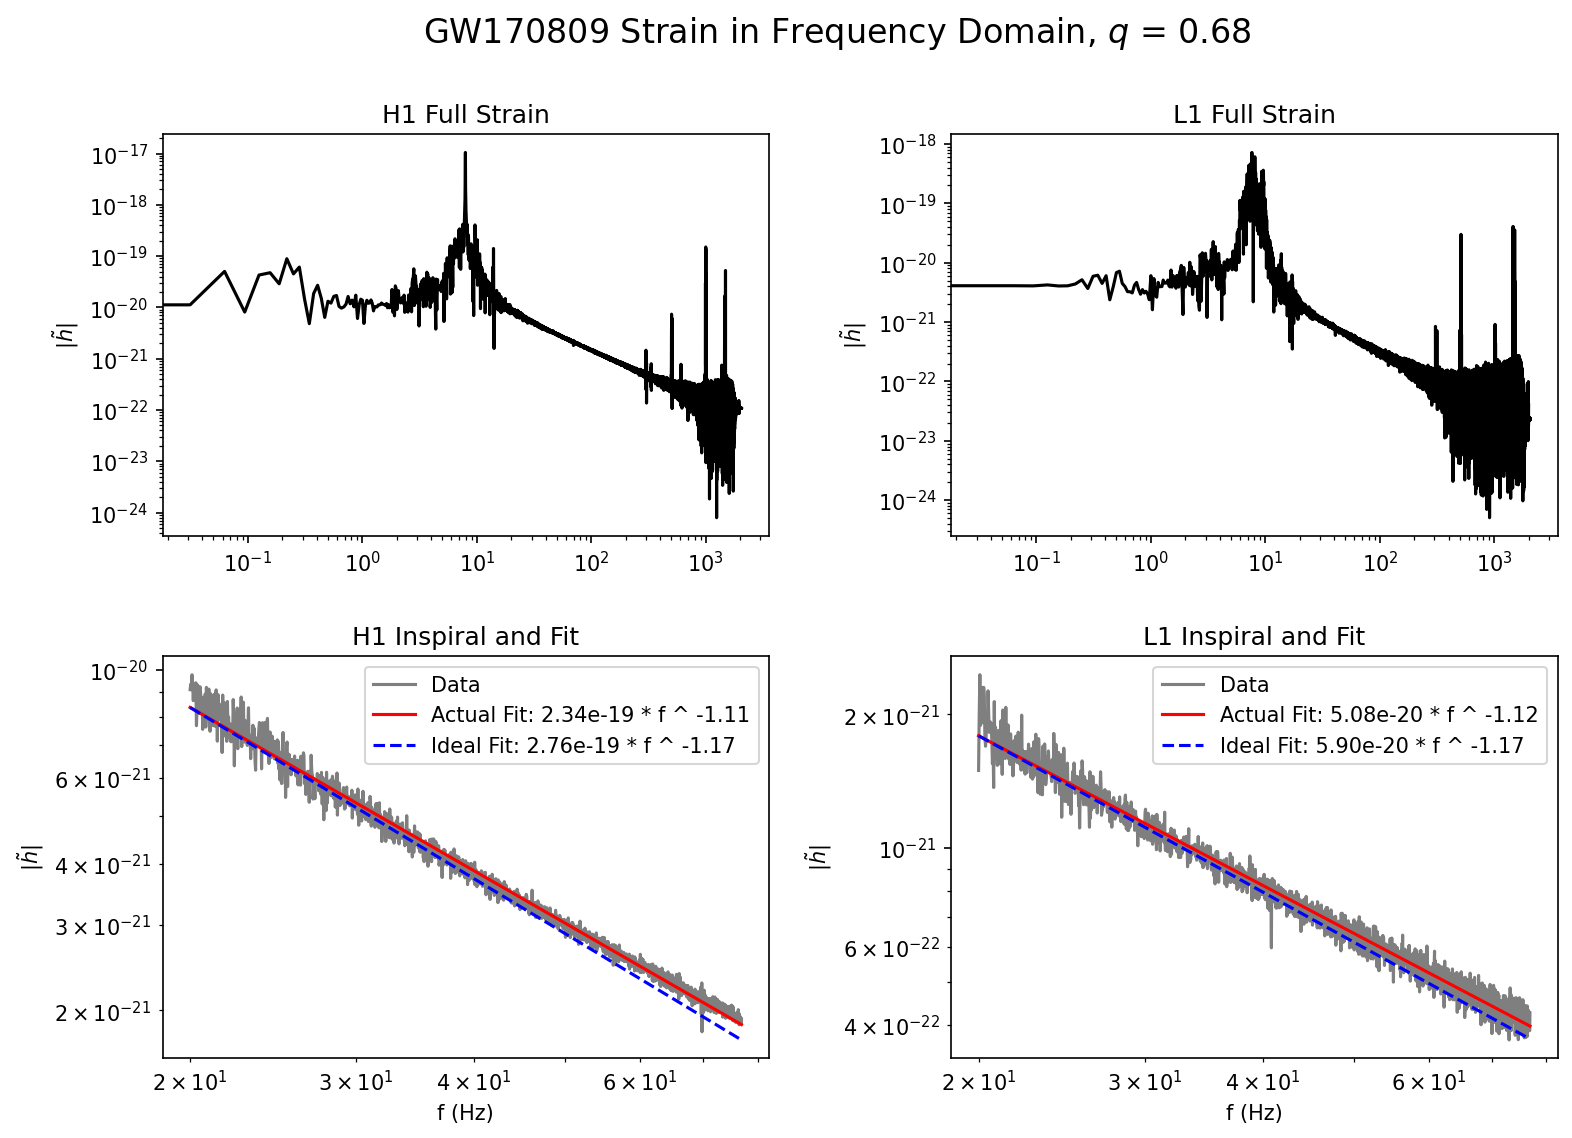

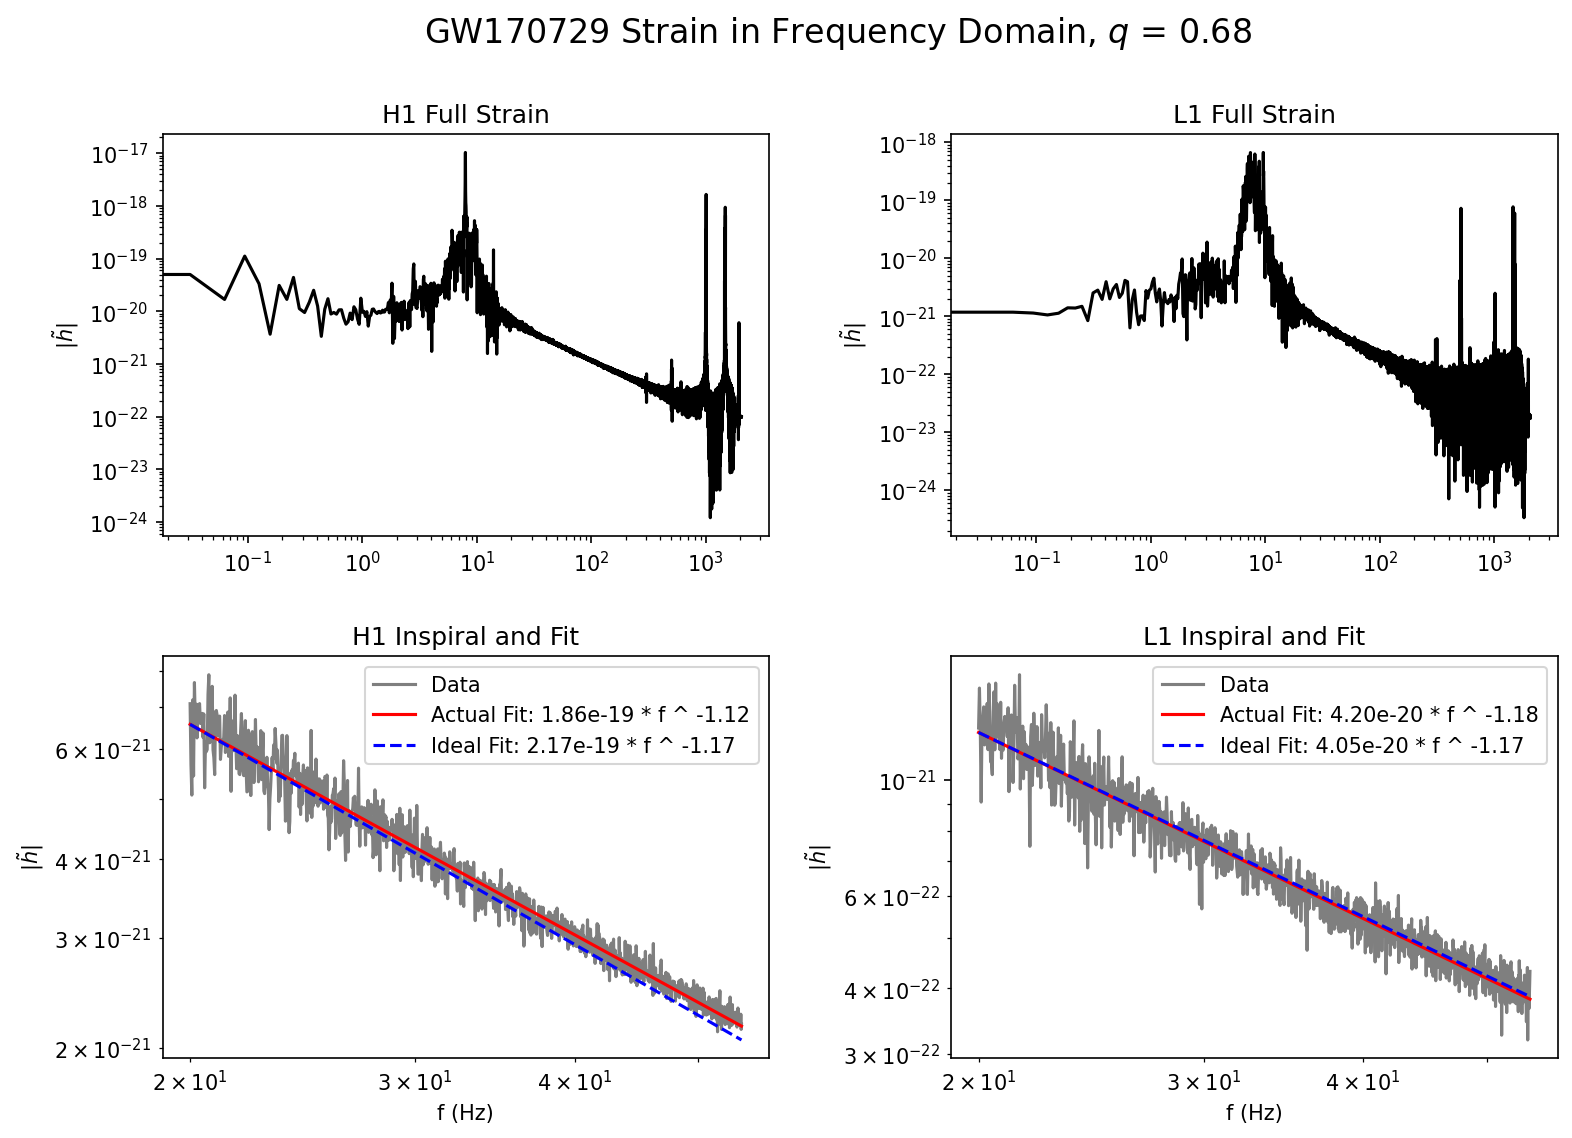

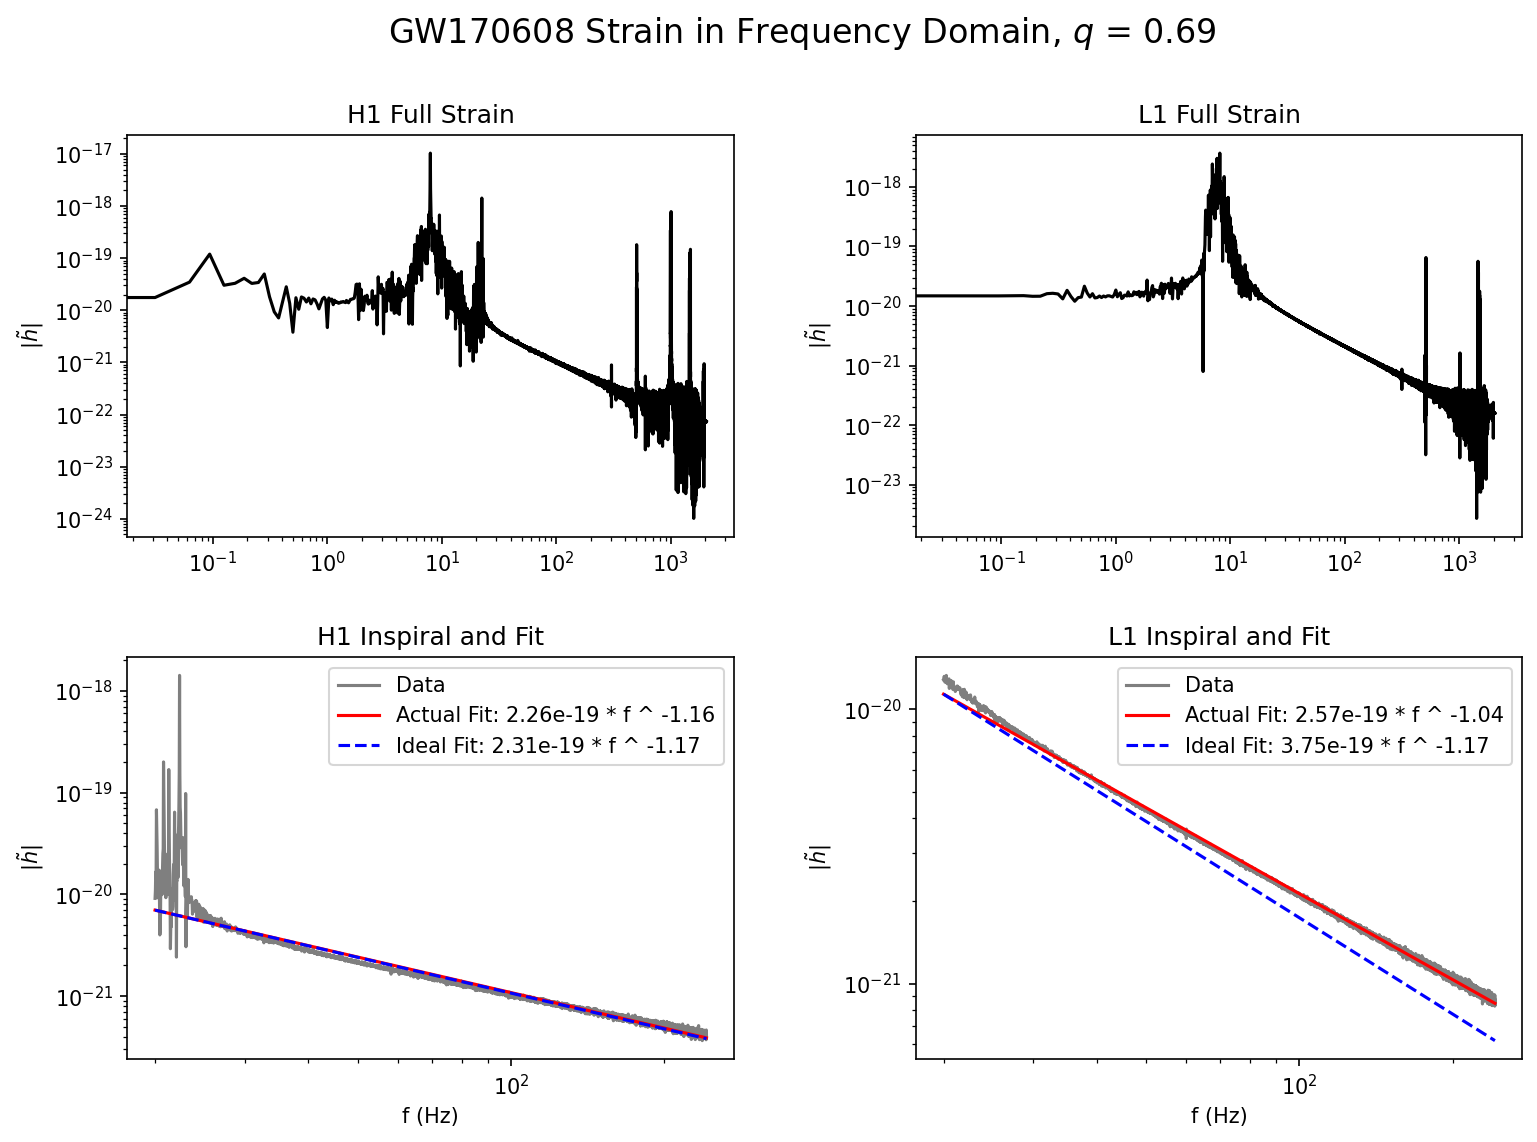

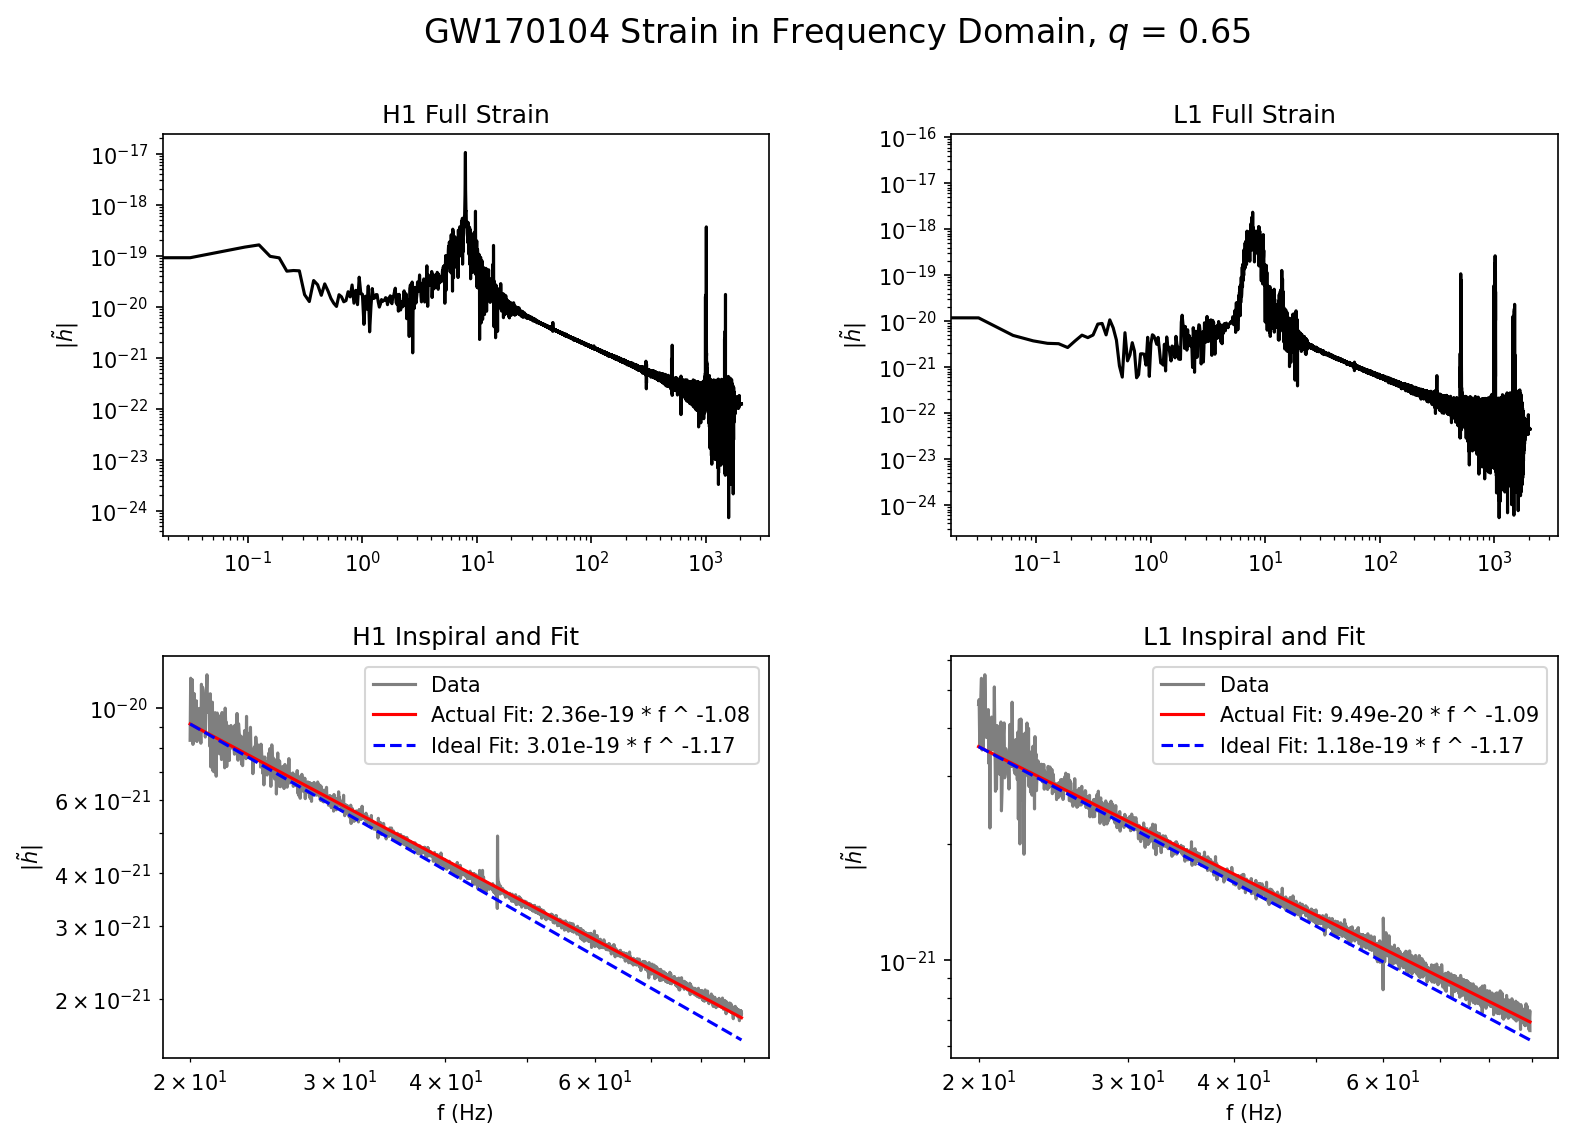

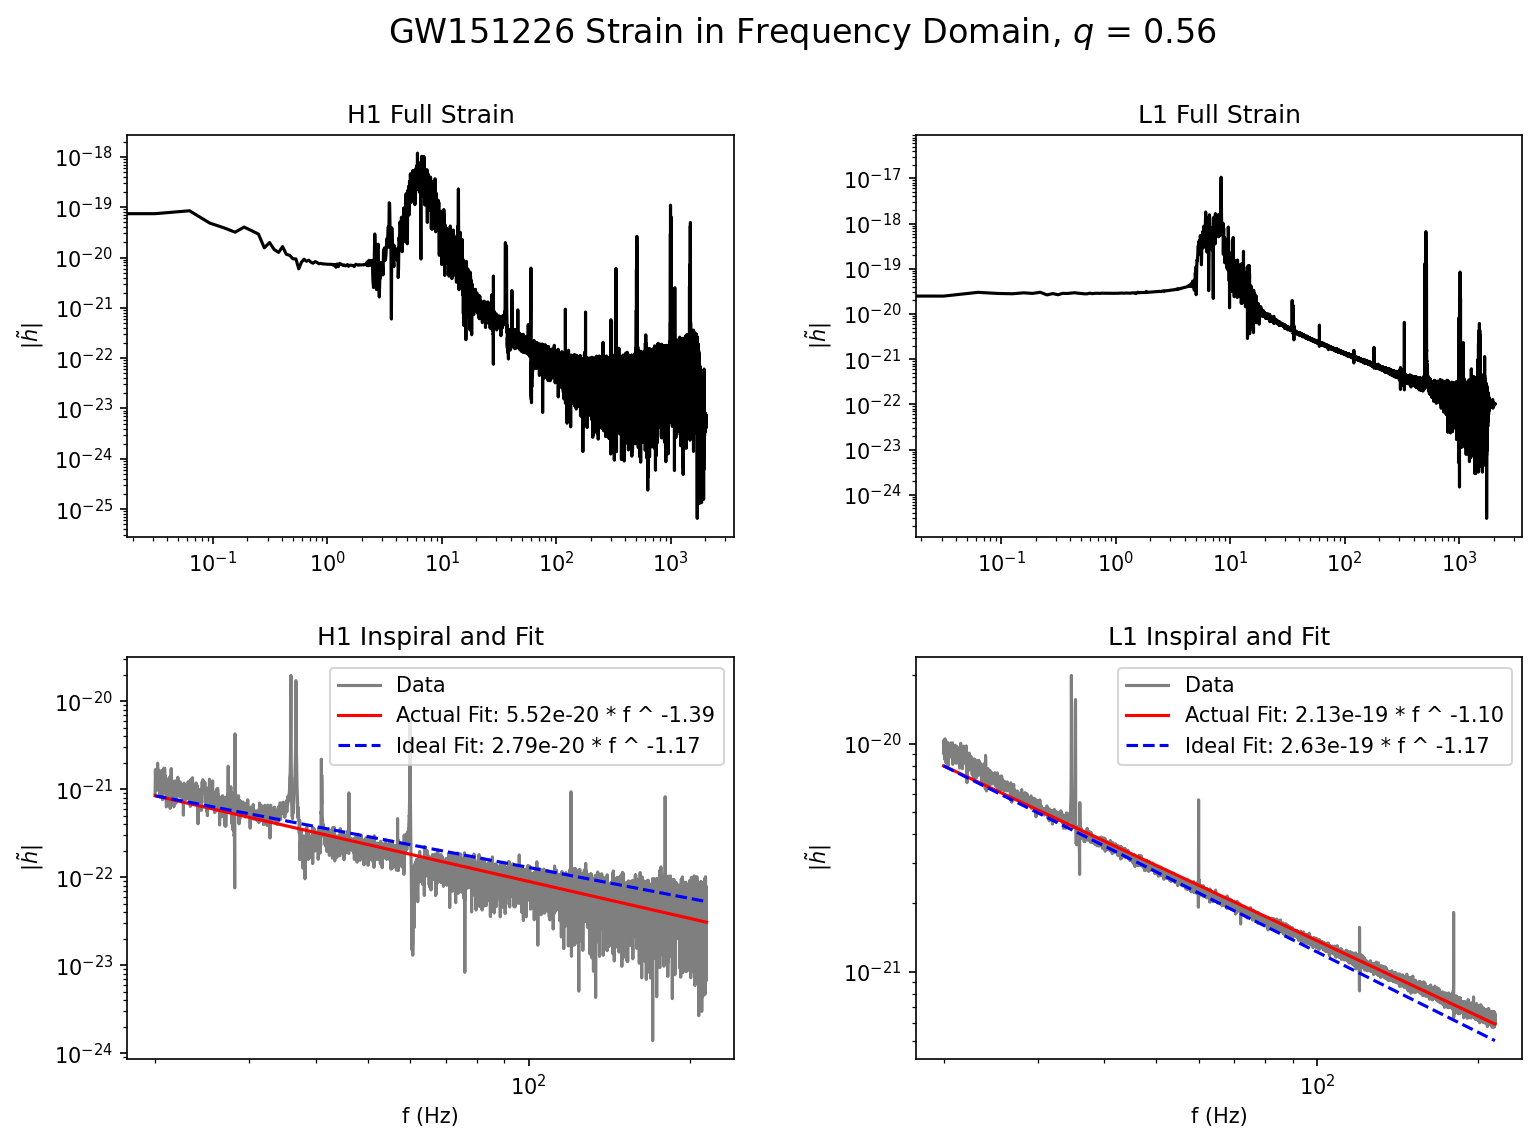

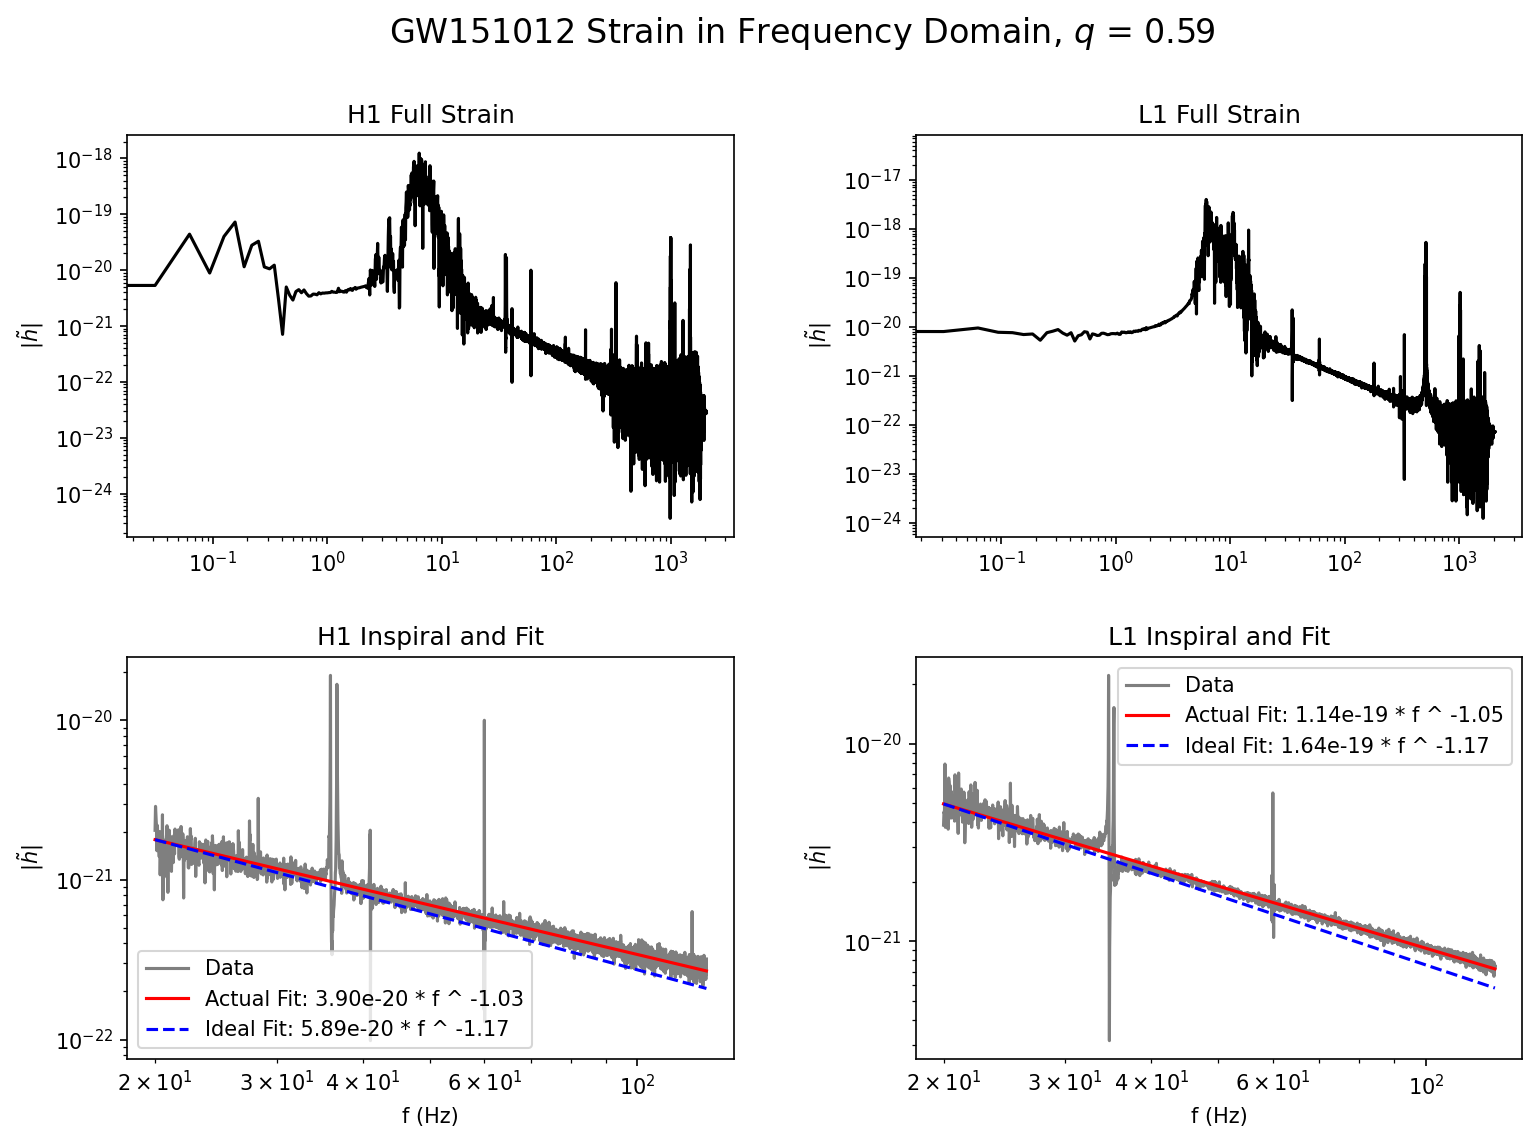

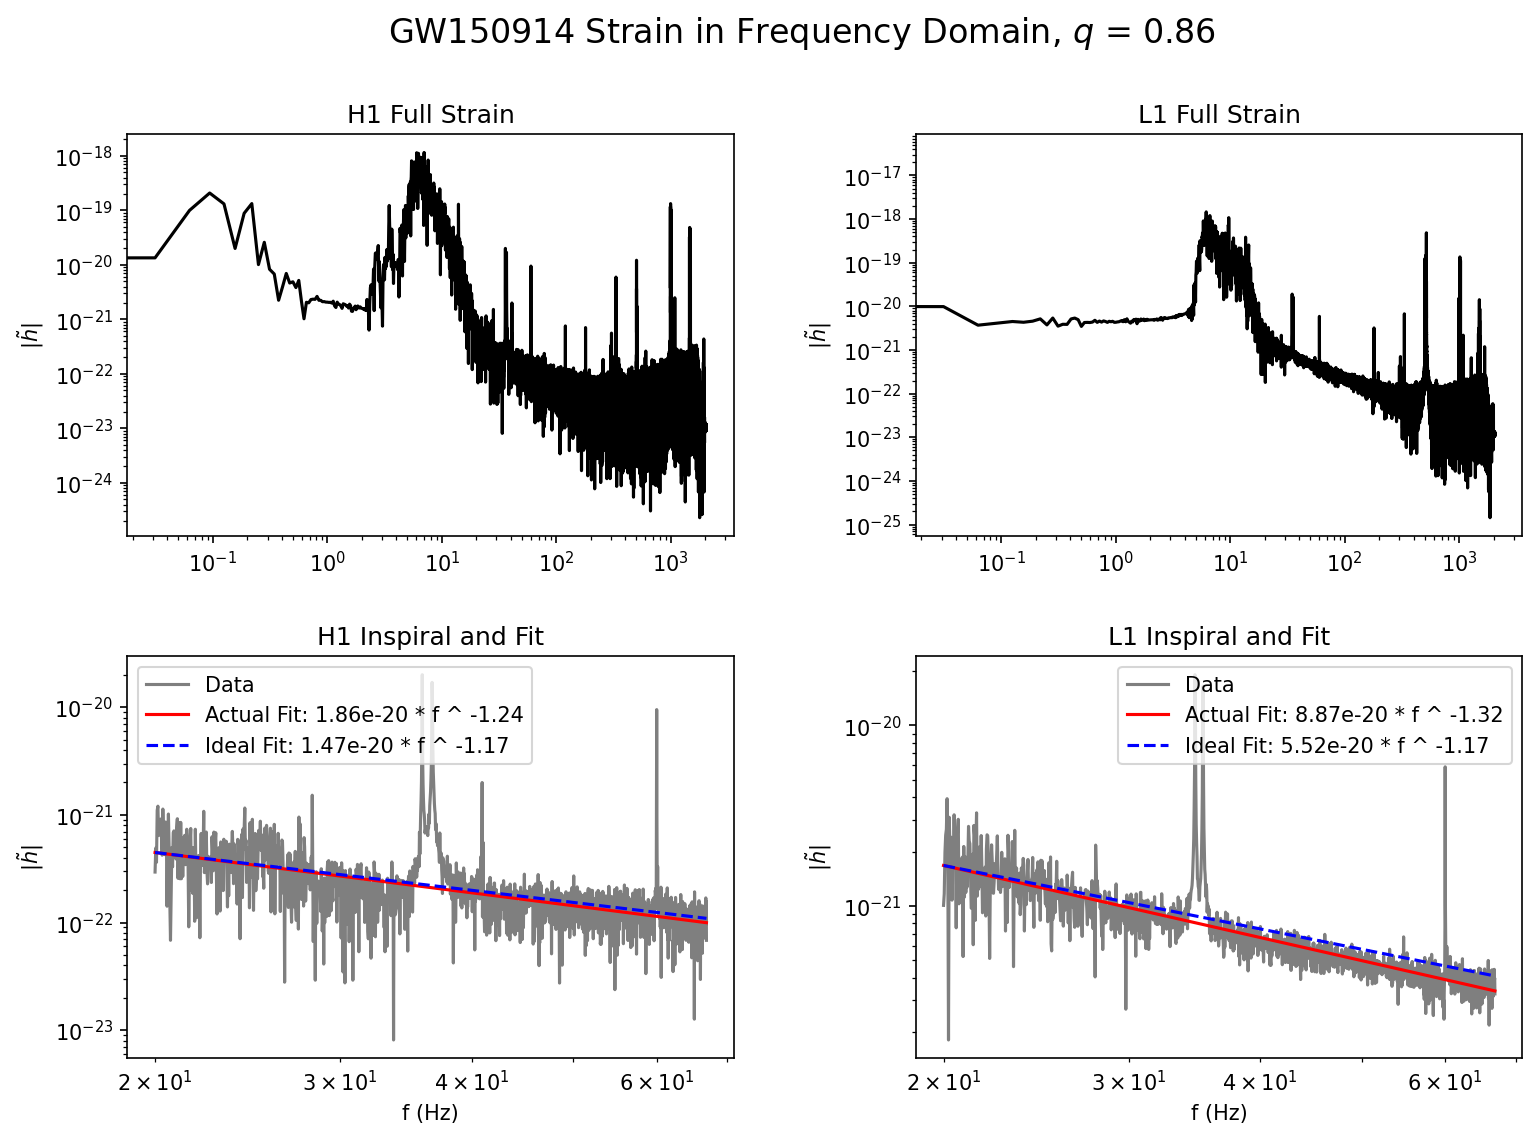

In [21]:
for merger_name in catalog.Catalog():
    merger = catalog.Merger(merger_name[:-3])
    plot_merger_and_fit(merger)

# try noise-filtering techniques

The Savitzky-Golay filter, implemented as `savgol_filter` in the `scipy.signal` module, is a type of smoothing filter that can be applied to any one-dimensional array of data. It does not specifically require time-domain data.

However, it's important to note that the Savitzky-Golay filter is a type of low-pass filter, meaning it smooths out high-frequency fluctuations in the data. When applied to time-domain data, it smooths out rapid changes in time. When applied to frequency-domain data, it smooths out rapid changes in frequency, which might not be what you want, especially if you're interested in specific frequency components.

In your code, you're applying the Savitzky-Golay filter to both time-domain data (`ts_han`) and frequency-domain data (`fs_han`). This is technically correct, but the interpretation of the results will be different in each case.

In the time domain, the Savitzky-Golay filter is smoothing out high-frequency time fluctuations, leaving the low-frequency trend of the data (the continuum). In the frequency domain, the Savitzky-Golay filter is smoothing out high-frequency frequency fluctuations, which might not correspond to the continuum of the original time-domain data.

If you want to find the continuum of frequency-domain data, a more common approach might be to fit a model to the data (such as a power-law or a polynomial) and subtract this model from the data.

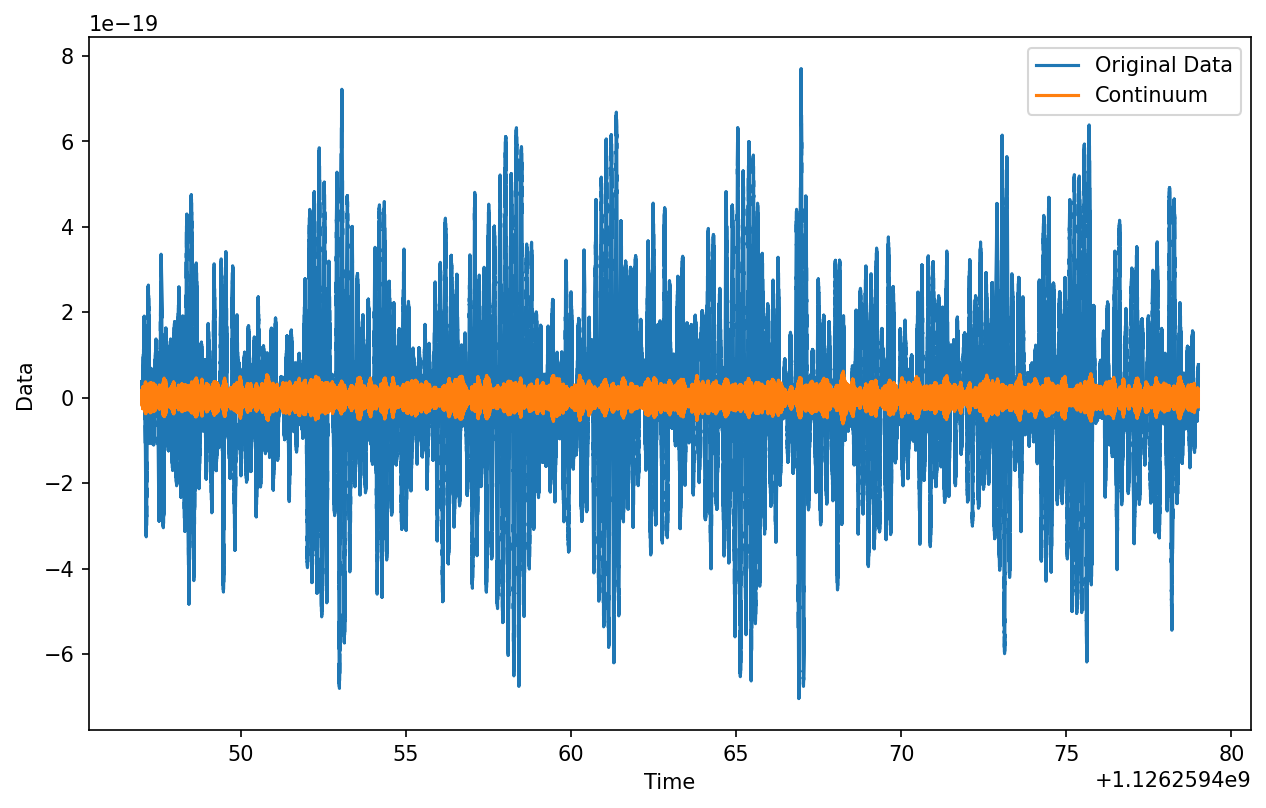

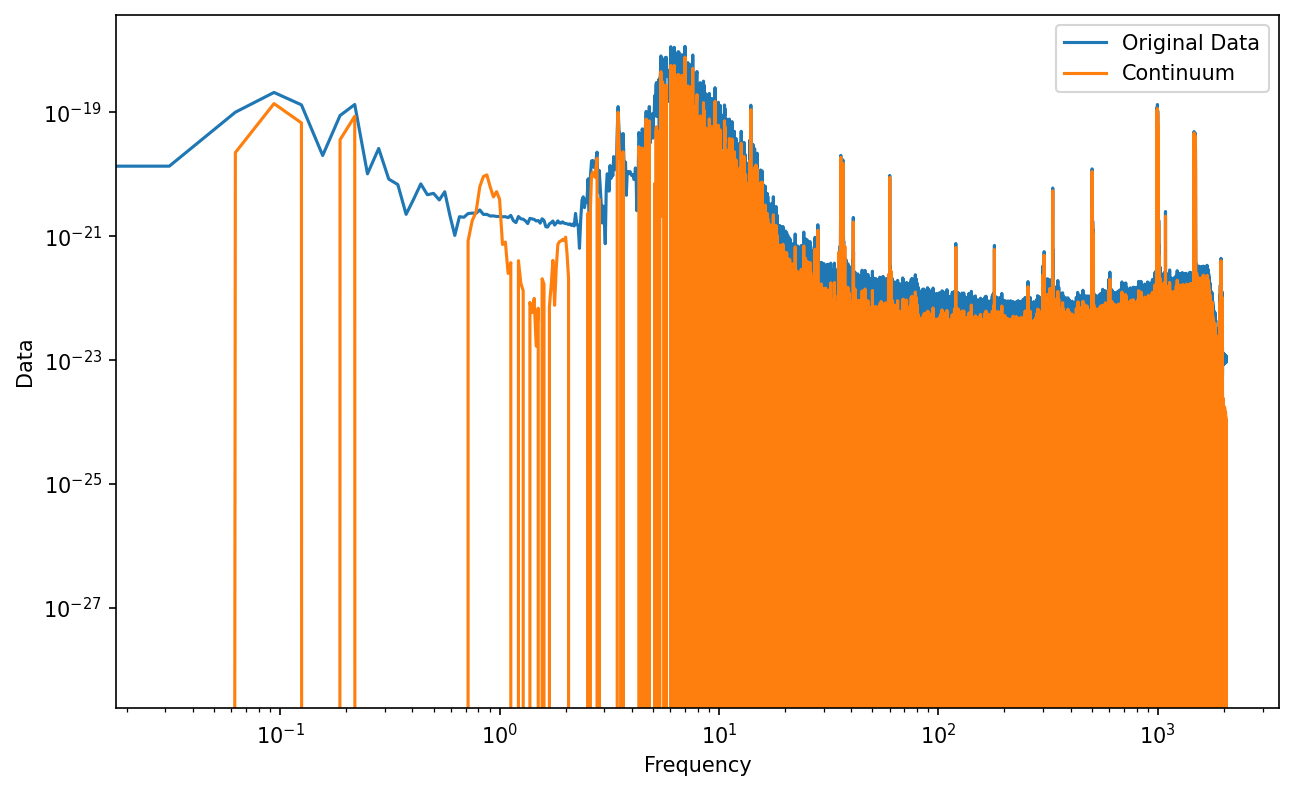

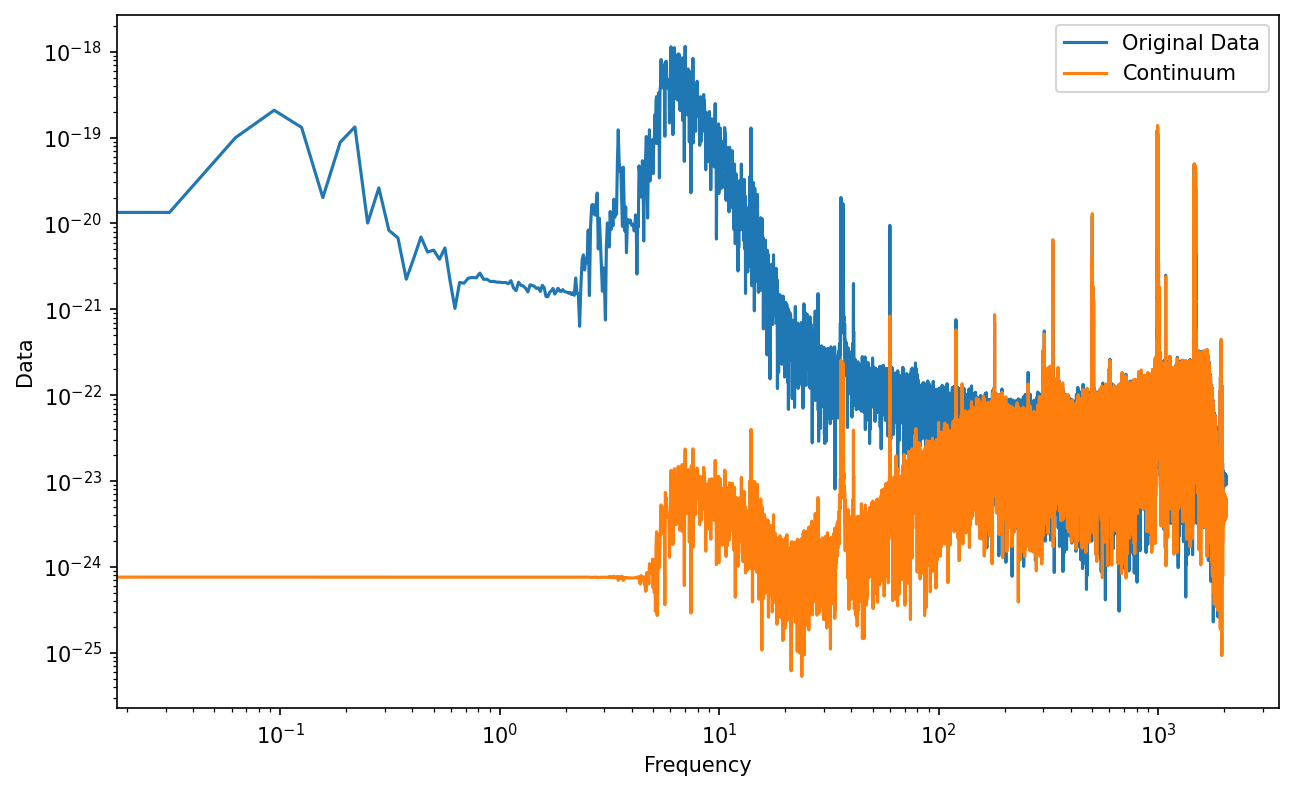

In [12]:
from scipy.signal import savgol_filter  # type: ignore

m = catalog.Merger("GW150914")

ts_han = m.strain("H1")
time_arr = ts_han.sample_times

# Assuming `data` and `time` are your data and time arrays
ts_smoothed = savgol_filter(ts_han, window_length=51, polyorder=3)

# The continuum is the difference between the original data and the smoothed data
ts_continuum = ts_han - ts_smoothed

# Plot the original data and the continuum
plt.figure(figsize=(10, 6))
plt.plot(time_arr, ts_han, label="Original Data")
plt.plot(time_arr, ts_continuum, label="Continuum")
plt.xlabel("Time")
plt.ylabel("Data")
plt.legend()
plt.show()

# try with frequency series
fs_han = np.abs(ts_han.to_frequencyseries())
f_arr_han = fs_han.sample_frequencies

fs_smoothed = savgol_filter(fs_han, window_length=51, polyorder=3)
fs_continuum = fs_han - fs_smoothed

# Plot the original data and the continuum
plt.figure(figsize=(10, 6))
plt.loglog(f_arr_han, fs_han, label="Original Data")
plt.loglog(f_arr_han, fs_continuum, label="Continuum")
plt.xlabel("Frequency")
plt.ylabel("Data")
plt.legend()
plt.show()

# convert ts_continuum to frequency series
fs_filtered = np.abs(ts_continuum.to_frequencyseries())

plt.figure(figsize=(10, 6))
plt.loglog(f_arr_han, fs_han, label="Original Data")
plt.loglog(f_arr_han, fs_filtered, label="Continuum")
plt.xlabel("Frequency")
plt.ylabel("Data")
plt.legend()
plt.show()